In [3]:
#load in list of URLs
import pandas as pd

#load podcast root URLs
floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'itunes_categories' #This is a list of iTunes genres and their URLs
podcast_categories = pd.read_csv(floc+fname)
print(podcast_categories)
print(len(podcast_categories))

                   category                                                url
0                       art  https://itunes.apple.com/us/genre/podcasts-art...
1                  business  https://itunes.apple.com/us/genre/podcasts-bus...
2                    comedy  https://itunes.apple.com/us/genre/podcasts-com...
3                 education  https://itunes.apple.com/us/genre/podcasts-edu...
4                     games  https://itunes.apple.com/us/genre/podcasts-gam...
5   government organization  https://itunes.apple.com/us/genre/podcasts-gov...
6                    health  https://itunes.apple.com/us/genre/podcasts-hea...
7                    family  https://itunes.apple.com/us/genre/podcasts-kid...
8                     music  https://itunes.apple.com/us/genre/podcasts-mus...
9                  politics  https://itunes.apple.com/us/genre/podcasts-new...
10                 religion  https://itunes.apple.com/us/genre/podcasts-rel...
11                  science  https://itunes.apple.co

In [4]:
#Grab the names and links for each podcast!
import requests
import bs4 #BeautifulSoup
import time
import re
import numpy as np

podcast_leading_character = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ*'#Here are possible leading characters for podcast names


#gets the titles of all podcasts on an iTunes podcast category page
def get_podcast_titles_iTunes(soup,target_url = 'https://itunes.apple.com/us/podcast/'):
    
    links = []
    titles = []
    ids = []
    for link in soup.find_all('a'):
        if target_url in link.get('href'):
            links.append(link.get('href'))
            titles.append(link.contents[0])
            ids.append(link.get('href').split("/id",1)[1])
    return links, titles, ids

#count pages on an iTunes podcast category page
def count_pages_iTunes(soup):
    flag = 0
    prev_link = None
    for link in soup.find_all('a'):
        #print(link.contents)
        if link.contents[0]=='#':
            flag = 1
        if(flag):
            if(link.contents[0].isdigit()):
                prev_link = link
            else:
                if(link.contents[0]!='#'):
                    if(prev_link is None):
                        return 1
                    else:
                        return int(prev_link.contents[0])
    raise ValueError()
    
#safe request that keeps on trying if it gets a 403.
def persistent_request(url,retry_time = 60):
    flag = 1
    while(flag):
        page = requests.get(url).json()
        if(page.status_code!=200):
            flag = 1
            print('Error '+str(page.status_code)+'. Retrying in '+str(retry_time)+' sec')
            time.sleep(retry_time)
        else:
            flag = 0
    return page

inter_query_interval = 0 #seconds
inter_query_variance = 0


#store the podcast name, id, id url, time accessed, and url from where it was obtained. 
url_data = []

In [5]:
#Grab the names of all of the podcasts from iTunes
#IMPORTANT: these titles are truncated. When searching for id, grab both feed and title
for i in range(0,len(podcast_categories)):
    print('#########Accessing category '+str(i)+'/'+str(len(podcast_categories)))
    
    #iterate through leading characters
    for c in podcast_leading_character:
        print('######Accessing character '+c)
        base_url = re.sub('letter=.','letter='+c,podcast_categories.iloc[i]['url'])
        #request first & count pages
        request_time = time.time()
        query_time = np.random.randn()*inter_query_variance+inter_query_interval
        page = persistent_request(base_url)
        soup = bs4.BeautifulSoup(page.text,"html5lib")
        npages = count_pages_iTunes(soup)
        
        #iterate through page number
        for k in range(1,npages+1):
            print('###Accessing page #'+str(k)+'/'+str(npages))
            if(k!=1):
                #generate url
                url = re.sub('page=.','page='+str(k),base_url)
                request_time = time.time()
                page = persistent_request(url)
                soup = bs4.BeautifulSoup(page.text,"html5lib")
            else:
                url = base_url
            #get podcast titles
            links,titles,ids = get_podcast_titles_iTunes(soup)
            
            #store the podcast name, id, id url, time accessed, and url from where it was obtained. 
            for x in list(zip(titles,ids,links)):
                url_data.append([x[0],x[1],x[2],request_time,url])
            
            #file them away
            iter_end_time = time.time()
            duration = iter_end_time - request_time
            time.sleep(max(0,query_time-(duration)))
                              
url_df = pd.DataFrame(url_data,columns=['name','id','url','time_accessed','query_url'])


#########Accessing category 0/16
######Accessing character A
###Accessing page #1/13
###Accessing page #2/13
###Accessing page #3/13
###Accessing page #4/13
###Accessing page #5/13
###Accessing page #6/13
###Accessing page #7/13
###Accessing page #8/13
###Accessing page #9/13
###Accessing page #10/13
###Accessing page #11/13


KeyboardInterrupt: 

In [97]:
#save the url dataframe
import pickle
floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'podcast_urls'+str(int(time.time()))
url_df.to_csv(floc+fname)

In [1]:
#load in URL dataframe
import pandas as pd

#load it in
floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'podcast_urls1528605993'
url_df = pd.read_csv(floc+fname)
url_df.drop_duplicates(['id'],inplace=True)

In [2]:
#Clean up IDs
for rep in range(0,2):
    ids = url_df['id'].get_values()
    for i in range(0,len(ids)):
        #print(i)
        if(isinstance(ids[i],str)):
            if(not ids[i].isdigit()): 
                ids[i] = ids[i].split("/id",1)[1]
    url_df['id'] = ids

In [3]:
#Setup the components of querying the iTunes API for podcast RSS feeds.
import os
import random


'''
Here is some code that swaps proxy servers when we get locked out by the iTunes API. 
This was built to get around rate limits, but this ended up not being necessary.
...
I felt so smart for building this, so it's irrelevance is bittersweet.
'''
# #manages random connections to Private Internet Access
# class PIAConnector:
#     def __init__(self):
#         self.connections = ['PIA - US Las Vegas', 'PIA - US New York City', 'PIA - US Midwest', 
#                'PIA - US Atlanta', 'PIA - US Seattle', 'PIA - US East', 
#                'PIA - US Chicago', 'PIA - US West', 'PIA - US Silicon Valley', 
#                'PIA - US Houston', 'PIA - US Florida', 'PIA - US California', 'PIA - US Texas']
#         self.used_connections = []
    
#     #disconnect.
#     def disconnect(self):
#         os.system('pypia -d')
        
#     #connect to random server that we haven't connected to before.
#     def new_connection(self):
#         if(len(self.connections)==0):
#             self.connections = list(self.used_connections)
#             self.used_connections = []
#             self.disconnect()
#         random.shuffle(self.connections)
#         new_connect = self.connections.pop()
#         pypia_command = "pypia -c '"+new_connect+"'"
#         self.used_connections.append(new_connect)
#         os.system(pypia_command)
#         print(pypia_command)

# #This request wrapper will switch servers if it gets a 403. 
# def dodgy_request(url,conn):
#     flag = 1
#     while(flag):
#         page = requests.get(url)
#         if(page.status_code==403):
#             flag = 1
#             print('Error '+str(page.status_code)+'. Swapping server.')
#             conn.new_connection()
#         elif(page.status_code==200):
#             flag = 0
#         else:
#             raise ValueError('Unrecognized status code, '+str(page.status_code))
#     return page

#safe request that keeps on trying if it gets a 403.
def persistent_request(url,retry_time = 60):
    flag = 1
    while(flag):
        page = requests.get(url)
        if(page.status_code!=200):
            flag = 1
            print('Error '+str(page.status_code)+'. Retrying in '+str(retry_time)+' sec')
            time.sleep(retry_time)
        else:
            flag = 0
    return page

#wrapper for looking up a set of IDs on iTunes
def lookup_id_iTunes(id):
    return persistent_request('https://itunes.apple.com/lookup?id=' + str(id))



In [6]:
#Queries the iTunes API to get all of the RSS feeds
import numpy as np
import time
import requests

#setup ID 
def lookup_id_iTunes(id):
    return persistent_request('https://itunes.apple.com/lookup?id=' + str(id))


chunk_size = 200

pages = []
duration = 0
for i in range(0, len(url_df), chunk_size):
    print('###### ' + str(i) + ' to ' + str(i+chunk_size) + 
          ' (last iteration '+ str(np.floor(duration)) + ')' )
    start_time = time.time()
    df_subset = url_df.iloc[i:np.min([len(url_df),(i+chunk_size)])]
    search_url = ','.join([str(x) for x in df_subset['id'].get_values()])
    pages.append(lookup_id_iTunes(search_url))
    stop_time = time.time()
    duration = stop_time - start_time


###### 0 to 200 (last iteration 0.0)
###### 200 to 400 (last iteration 0.0)
###### 400 to 600 (last iteration 0.0)
###### 600 to 800 (last iteration 0.0)
###### 800 to 1000 (last iteration 0.0)
###### 1000 to 1200 (last iteration 0.0)
###### 1200 to 1400 (last iteration 0.0)
###### 1400 to 1600 (last iteration 0.0)
###### 1600 to 1800 (last iteration 0.0)
###### 1800 to 2000 (last iteration 0.0)
###### 2000 to 2200 (last iteration 0.0)
###### 2200 to 2400 (last iteration 0.0)
###### 2400 to 2600 (last iteration 0.0)
###### 2600 to 2800 (last iteration 0.0)
###### 2800 to 3000 (last iteration 0.0)
###### 3000 to 3200 (last iteration 0.0)
###### 3200 to 3400 (last iteration 0.0)
###### 3400 to 3600 (last iteration 0.0)
###### 3600 to 3800 (last iteration 0.0)
###### 3800 to 4000 (last iteration 0.0)
###### 4000 to 4200 (last iteration 0.0)
###### 4200 to 4400 (last iteration 0.0)
###### 4400 to 4600 (last iteration 0.0)
###### 4600 to 4800 (last iteration 0.0)
###### 4800 to 5000 (last i

###### 38800 to 39000 (last iteration 0.0)
###### 39000 to 39200 (last iteration 1.0)
###### 39200 to 39400 (last iteration 0.0)
###### 39400 to 39600 (last iteration 1.0)
###### 39600 to 39800 (last iteration 1.0)
###### 39800 to 40000 (last iteration 1.0)
###### 40000 to 40200 (last iteration 1.0)
###### 40200 to 40400 (last iteration 1.0)
###### 40400 to 40600 (last iteration 0.0)
###### 40600 to 40800 (last iteration 0.0)
###### 40800 to 41000 (last iteration 0.0)
###### 41000 to 41200 (last iteration 0.0)
###### 41200 to 41400 (last iteration 0.0)
###### 41400 to 41600 (last iteration 1.0)
###### 41600 to 41800 (last iteration 1.0)
###### 41800 to 42000 (last iteration 0.0)
###### 42000 to 42200 (last iteration 0.0)
###### 42200 to 42400 (last iteration 1.0)
###### 42400 to 42600 (last iteration 0.0)
###### 42600 to 42800 (last iteration 0.0)
###### 42800 to 43000 (last iteration 1.0)
###### 43000 to 43200 (last iteration 0.0)
###### 43200 to 43400 (last iteration 0.0)
###### 4340

###### 77000 to 77200 (last iteration 0.0)
###### 77200 to 77400 (last iteration 1.0)
###### 77400 to 77600 (last iteration 1.0)
###### 77600 to 77800 (last iteration 1.0)
###### 77800 to 78000 (last iteration 0.0)
###### 78000 to 78200 (last iteration 0.0)
###### 78200 to 78400 (last iteration 0.0)
###### 78400 to 78600 (last iteration 0.0)
###### 78600 to 78800 (last iteration 1.0)
###### 78800 to 79000 (last iteration 0.0)
###### 79000 to 79200 (last iteration 0.0)
###### 79200 to 79400 (last iteration 1.0)
###### 79400 to 79600 (last iteration 0.0)
###### 79600 to 79800 (last iteration 0.0)
###### 79800 to 80000 (last iteration 0.0)
###### 80000 to 80200 (last iteration 0.0)
###### 80200 to 80400 (last iteration 1.0)
###### 80400 to 80600 (last iteration 0.0)
###### 80600 to 80800 (last iteration 1.0)
###### 80800 to 81000 (last iteration 0.0)
###### 81000 to 81200 (last iteration 1.0)
###### 81200 to 81400 (last iteration 0.0)
###### 81400 to 81600 (last iteration 0.0)
###### 8160

###### 114600 to 114800 (last iteration 0.0)
###### 114800 to 115000 (last iteration 0.0)
###### 115000 to 115200 (last iteration 0.0)
###### 115200 to 115400 (last iteration 0.0)
###### 115400 to 115600 (last iteration 0.0)
###### 115600 to 115800 (last iteration 0.0)
###### 115800 to 116000 (last iteration 0.0)
###### 116000 to 116200 (last iteration 0.0)
###### 116200 to 116400 (last iteration 0.0)
###### 116400 to 116600 (last iteration 0.0)
###### 116600 to 116800 (last iteration 1.0)
###### 116800 to 117000 (last iteration 0.0)
###### 117000 to 117200 (last iteration 0.0)
###### 117200 to 117400 (last iteration 0.0)
###### 117400 to 117600 (last iteration 0.0)
###### 117600 to 117800 (last iteration 0.0)
###### 117800 to 118000 (last iteration 1.0)
###### 118000 to 118200 (last iteration 0.0)
###### 118200 to 118400 (last iteration 1.0)
###### 118400 to 118600 (last iteration 0.0)
###### 118600 to 118800 (last iteration 0.0)
###### 118800 to 119000 (last iteration 1.0)
###### 119

###### 151200 to 151400 (last iteration 0.0)
###### 151400 to 151600 (last iteration 1.0)
###### 151600 to 151800 (last iteration 1.0)
###### 151800 to 152000 (last iteration 0.0)
###### 152000 to 152200 (last iteration 1.0)
###### 152200 to 152400 (last iteration 0.0)
###### 152400 to 152600 (last iteration 0.0)
###### 152600 to 152800 (last iteration 0.0)
###### 152800 to 153000 (last iteration 0.0)
###### 153000 to 153200 (last iteration 0.0)
###### 153200 to 153400 (last iteration 1.0)
###### 153400 to 153600 (last iteration 0.0)
###### 153600 to 153800 (last iteration 0.0)
###### 153800 to 154000 (last iteration 0.0)
###### 154000 to 154200 (last iteration 0.0)
###### 154200 to 154400 (last iteration 0.0)
###### 154400 to 154600 (last iteration 0.0)
###### 154600 to 154800 (last iteration 0.0)
###### 154800 to 155000 (last iteration 0.0)
###### 155000 to 155200 (last iteration 0.0)
###### 155200 to 155400 (last iteration 0.0)
###### 155400 to 155600 (last iteration 0.0)
###### 155

###### 187800 to 188000 (last iteration 1.0)
###### 188000 to 188200 (last iteration 0.0)
###### 188200 to 188400 (last iteration 0.0)
###### 188400 to 188600 (last iteration 0.0)
###### 188600 to 188800 (last iteration 0.0)
###### 188800 to 189000 (last iteration 1.0)
###### 189000 to 189200 (last iteration 0.0)
###### 189200 to 189400 (last iteration 0.0)
###### 189400 to 189600 (last iteration 0.0)
###### 189600 to 189800 (last iteration 0.0)
###### 189800 to 190000 (last iteration 0.0)
###### 190000 to 190200 (last iteration 1.0)
###### 190200 to 190400 (last iteration 1.0)
###### 190400 to 190600 (last iteration 1.0)
###### 190600 to 190800 (last iteration 0.0)
###### 190800 to 191000 (last iteration 0.0)
###### 191000 to 191200 (last iteration 0.0)
###### 191200 to 191400 (last iteration 1.0)
###### 191400 to 191600 (last iteration 1.0)
###### 191600 to 191800 (last iteration 0.0)
###### 191800 to 192000 (last iteration 0.0)
###### 192000 to 192200 (last iteration 1.0)
###### 192

###### 224400 to 224600 (last iteration 0.0)
###### 224600 to 224800 (last iteration 0.0)
###### 224800 to 225000 (last iteration 1.0)
###### 225000 to 225200 (last iteration 1.0)
###### 225200 to 225400 (last iteration 1.0)
###### 225400 to 225600 (last iteration 0.0)
###### 225600 to 225800 (last iteration 1.0)
###### 225800 to 226000 (last iteration 0.0)
###### 226000 to 226200 (last iteration 0.0)
###### 226200 to 226400 (last iteration 1.0)
###### 226400 to 226600 (last iteration 0.0)
###### 226600 to 226800 (last iteration 2.0)
###### 226800 to 227000 (last iteration 1.0)
###### 227000 to 227200 (last iteration 1.0)
###### 227200 to 227400 (last iteration 0.0)
###### 227400 to 227600 (last iteration 0.0)
###### 227600 to 227800 (last iteration 0.0)
###### 227800 to 228000 (last iteration 0.0)
###### 228000 to 228200 (last iteration 0.0)
###### 228200 to 228400 (last iteration 1.0)
###### 228400 to 228600 (last iteration 0.0)
###### 228600 to 228800 (last iteration 0.0)
###### 228

###### 261000 to 261200 (last iteration 1.0)
###### 261200 to 261400 (last iteration 0.0)
###### 261400 to 261600 (last iteration 1.0)
###### 261600 to 261800 (last iteration 0.0)
###### 261800 to 262000 (last iteration 2.0)
###### 262000 to 262200 (last iteration 1.0)
###### 262200 to 262400 (last iteration 0.0)
###### 262400 to 262600 (last iteration 0.0)
###### 262600 to 262800 (last iteration 0.0)
###### 262800 to 263000 (last iteration 0.0)
###### 263000 to 263200 (last iteration 0.0)
###### 263200 to 263400 (last iteration 0.0)
###### 263400 to 263600 (last iteration 1.0)
###### 263600 to 263800 (last iteration 0.0)
###### 263800 to 264000 (last iteration 0.0)
###### 264000 to 264200 (last iteration 0.0)
###### 264200 to 264400 (last iteration 0.0)
###### 264400 to 264600 (last iteration 0.0)
###### 264600 to 264800 (last iteration 1.0)
###### 264800 to 265000 (last iteration 0.0)
###### 265000 to 265200 (last iteration 0.0)
###### 265200 to 265400 (last iteration 0.0)
###### 265

###### 297600 to 297800 (last iteration 1.0)
###### 297800 to 298000 (last iteration 1.0)
###### 298000 to 298200 (last iteration 1.0)
###### 298200 to 298400 (last iteration 0.0)
###### 298400 to 298600 (last iteration 0.0)
###### 298600 to 298800 (last iteration 0.0)
###### 298800 to 299000 (last iteration 1.0)
###### 299000 to 299200 (last iteration 1.0)
###### 299200 to 299400 (last iteration 0.0)
###### 299400 to 299600 (last iteration 1.0)
###### 299600 to 299800 (last iteration 0.0)
###### 299800 to 300000 (last iteration 1.0)
###### 300000 to 300200 (last iteration 0.0)
###### 300200 to 300400 (last iteration 0.0)
###### 300400 to 300600 (last iteration 1.0)
###### 300600 to 300800 (last iteration 0.0)
###### 300800 to 301000 (last iteration 0.0)
###### 301000 to 301200 (last iteration 1.0)
###### 301200 to 301400 (last iteration 1.0)
###### 301400 to 301600 (last iteration 0.0)
###### 301600 to 301800 (last iteration 0.0)
###### 301800 to 302000 (last iteration 1.0)
###### 302

###### 334200 to 334400 (last iteration 1.0)
###### 334400 to 334600 (last iteration 0.0)
###### 334600 to 334800 (last iteration 0.0)
###### 334800 to 335000 (last iteration 0.0)
###### 335000 to 335200 (last iteration 1.0)
###### 335200 to 335400 (last iteration 0.0)
###### 335400 to 335600 (last iteration 0.0)
###### 335600 to 335800 (last iteration 1.0)
###### 335800 to 336000 (last iteration 0.0)
###### 336000 to 336200 (last iteration 0.0)
###### 336200 to 336400 (last iteration 0.0)
###### 336400 to 336600 (last iteration 0.0)
###### 336600 to 336800 (last iteration 0.0)
###### 336800 to 337000 (last iteration 0.0)
###### 337000 to 337200 (last iteration 0.0)
###### 337200 to 337400 (last iteration 0.0)
###### 337400 to 337600 (last iteration 0.0)
###### 337600 to 337800 (last iteration 0.0)
###### 337800 to 338000 (last iteration 1.0)
###### 338000 to 338200 (last iteration 0.0)
###### 338200 to 338400 (last iteration 0.0)
###### 338400 to 338600 (last iteration 0.0)
###### 338

###### 370800 to 371000 (last iteration 0.0)
###### 371000 to 371200 (last iteration 0.0)
###### 371200 to 371400 (last iteration 0.0)
###### 371400 to 371600 (last iteration 0.0)
###### 371600 to 371800 (last iteration 0.0)
###### 371800 to 372000 (last iteration 0.0)
###### 372000 to 372200 (last iteration 0.0)
###### 372200 to 372400 (last iteration 1.0)
###### 372400 to 372600 (last iteration 1.0)
###### 372600 to 372800 (last iteration 0.0)
###### 372800 to 373000 (last iteration 0.0)
###### 373000 to 373200 (last iteration 0.0)
###### 373200 to 373400 (last iteration 0.0)
###### 373400 to 373600 (last iteration 0.0)
###### 373600 to 373800 (last iteration 0.0)
###### 373800 to 374000 (last iteration 0.0)
###### 374000 to 374200 (last iteration 1.0)
###### 374200 to 374400 (last iteration 0.0)
###### 374400 to 374600 (last iteration 0.0)
###### 374600 to 374800 (last iteration 0.0)
###### 374800 to 375000 (last iteration 0.0)
###### 375000 to 375200 (last iteration 1.0)
###### 375

###### 407400 to 407600 (last iteration 0.0)
###### 407600 to 407800 (last iteration 0.0)
###### 407800 to 408000 (last iteration 0.0)
###### 408000 to 408200 (last iteration 0.0)
###### 408200 to 408400 (last iteration 0.0)
###### 408400 to 408600 (last iteration 0.0)
###### 408600 to 408800 (last iteration 0.0)
###### 408800 to 409000 (last iteration 0.0)
###### 409000 to 409200 (last iteration 0.0)
###### 409200 to 409400 (last iteration 0.0)
###### 409400 to 409600 (last iteration 1.0)
###### 409600 to 409800 (last iteration 1.0)
###### 409800 to 410000 (last iteration 0.0)
###### 410000 to 410200 (last iteration 1.0)
###### 410200 to 410400 (last iteration 0.0)
###### 410400 to 410600 (last iteration 0.0)
###### 410600 to 410800 (last iteration 1.0)
###### 410800 to 411000 (last iteration 0.0)
###### 411000 to 411200 (last iteration 0.0)
###### 411200 to 411400 (last iteration 0.0)
###### 411400 to 411600 (last iteration 1.0)
###### 411600 to 411800 (last iteration 0.0)
###### 411

413720


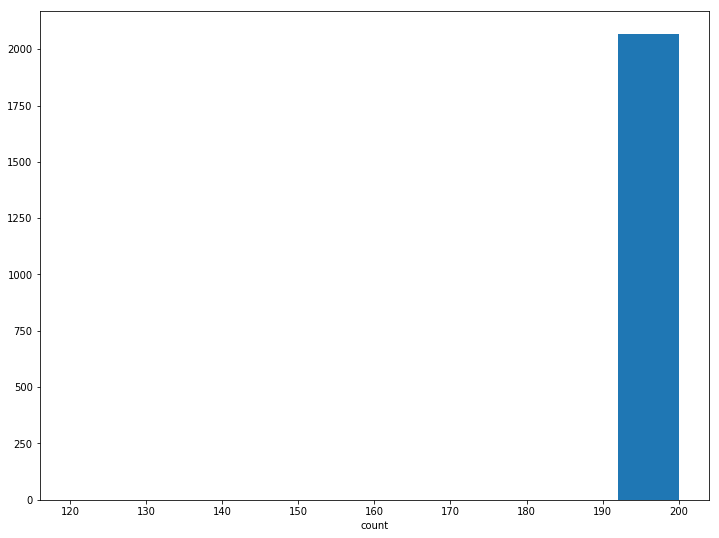

In [10]:
#plot the length of page vectors to make sure that scraping approximately worked
#Each page vector should be of length 200.
import matplotlib.pyplot as plt
from datetime import datetime

page_lengths = [len(x.json()['results']) for x in pages]

plt.figure(figsize=[12,9])
plt.hist(page_lengths)
plt.xlabel('# results')
plt.ylabel('count')
#print(len(url_df))

In [13]:
#save pages for later processing
import pickle

pickle.dump(pages,open(floc+'raw_itunes_requests'+str(int(time.time()))+'.pkl','wb'))

In [1]:
#load in raw iTunes requests
import pickle

floc = '/home/bmassi/Dropbox/professional/Insight/data/'
raw_itunes_requests = pickle.load(open(floc+'raw_itunes_requests1528609065.pkl','rb'))

In [2]:
#turn everything into a pandas dataframe
import pandas as pd

formatted_results = []
bads = []
cnames = ['']
for rir in raw_itunes_requests:
    for p in rir.json()['results']:
        if(p['kind']=='podcast'):
            formatted_results.append(p)

podcast_df = pd.DataFrame(formatted_results)

In [3]:
#take out rows that don't have RSS feeds
import numpy as np
podcast_df = podcast_df.loc[podcast_df['feedUrl'].isnull()==False]

#take out rows that don't have well-defined release dates
podcast_df['releaseDate'] = pd.to_datetime(podcast_df['releaseDate'])
podcast_df = podcast_df.loc[podcast_df['releaseDate'].isnull()==False]

In [4]:
#plot included podcasts as a function of update frequency
from datetime import datetime,timedelta
from matplotlib import pyplot as plt

upper_limit = 100
comparator_day = datetime(2018,6,11,14,5,23,424906)#This was "today" on Monday 6-11-18
npodcast = []
cutoffs = [i for i in range(1,upper_limit+1)]
for c in cutoffs:
    npodcast.append(np.sum(podcast_df['releaseDate'] > (comparator_day - timedelta(days=c))))

plt.plot(cutoffs,npodcast)
plt.xlabel('Time since last update threshold')
plt.ylabel('count')

Text(0,0.5,'count')

In [5]:
#filter out podcasts that weren't updated recently (look at fraction of remaining dataset as a function of cutoff)

target_cutoff = 7#filter out podcasts that weren't updated for 7 days
comparator_day = datetime(2018,6,11,14,5,23,424906)#This was "today" on Monday 6-11-18

podcast_df = podcast_df.loc[podcast_df['releaseDate'] > (comparator_day - timedelta(days=target_cutoff))]

print(len(podcast_df))

56943


In [7]:
#multithreaded RSS scrape
from multiprocessing import Pool
import socket
import time
import feedparser as fp
import requests

MAX_REQUEST_DURATION = 10 #seconds
socket.setdefaulttimeout(MAX_REQUEST_DURATION)

class ResponseCodeError(BaseException):
    pass

def safe_request(url):
    flag = 1
    while(flag):
        page = requests.get(url).json()
        if(page.status_code!=200):
            flag = 1
            print('Error '+str(page.status_code)+'. Retrying in '+str(retry_time)+' sec')
            time.sleep(retry_time)
        else:
            raise ResponseCodeError()
    return page

def feed_request(url):
    try:
        return (url,fp.parse(url))
    except:
        print('Error on ' + url)
        return (url,None)

    
floc = '/home/bmassi/Dropbox/professional/Insight/data/rss_data'
if __name__ == '__main__':
    p = Pool(8)
    chunk_size = 8*3
    save_every = 1000; #save and clear rss_feeds after this many feeds have been scraped.
    rss_feeds = []
    bads = []
    duration = 0
    j = 0
    filecounter = 0
    associator = str(int(time.time()))
    for i in range(0,len(podcast_df),chunk_size):
        print('###### ' + str(i) + ' to ' + str(i+chunk_size) + 
          ' (length= ' + str(len(podcast_df))+ '; last iteration '+ str(np.floor(duration)) + ')' )
        start_time = time.time()
        podcast_df.iloc[i:np.min([len(podcast_df),(i+chunk_size)])]
        try:
            rss_feeds.append(p.map(feed_request, podcast_df['feedUrl'].iloc[i:np.min([len(podcast_df),(i+chunk_size)])].get_values()))
        except:
            print('bad on '+ str(i) + ' to ' + str(i+chunk_size))
            for k in range(i,i+chunk_size):
                bads.append(k)
        stop_time = time.time()
        duration = stop_time - start_time
        if(j >= (save_every/chunk_size)):
            print('###Saving...')
            pickle.dump([rss_feeds,bads],open(floc+'raw_rss_and_bads_file'+
                              str(filecounter)+'_'+associator+'.pkl','wb'))
            print('###Saved!')
            #bads = []
            rss_feeds = []
            filecounter+=1
            j = -1
        j += 1
    p.close()
    pickle.dump([rss_feeds,bads],open(floc+'raw_rss_and_bads_file'+
                str(filecounter)+'_'+associator+'.pkl','wb'))
    
print('done!')

###### 0 to 24 (length= 56943; last iteration 0.0)
###### 24 to 48 (length= 56943; last iteration 2.0)
###### 48 to 72 (length= 56943; last iteration 1.0)
###### 72 to 96 (length= 56943; last iteration 3.0)
###### 96 to 120 (length= 56943; last iteration 2.0)
###### 120 to 144 (length= 56943; last iteration 2.0)
###### 144 to 168 (length= 56943; last iteration 1.0)
###### 168 to 192 (length= 56943; last iteration 1.0)
bad on 168 to 192
###### 192 to 216 (length= 56943; last iteration 12.0)
###### 216 to 240 (length= 56943; last iteration 10.0)
###### 240 to 264 (length= 56943; last iteration 10.0)
###### 264 to 288 (length= 56943; last iteration 1.0)
###### 288 to 312 (length= 56943; last iteration 2.0)
###### 312 to 336 (length= 56943; last iteration 2.0)
###### 336 to 360 (length= 56943; last iteration 3.0)
###### 360 to 384 (length= 56943; last iteration 2.0)
###### 384 to 408 (length= 56943; last iteration 10.0)
###### 408 to 432 (length= 56943; last iteration 2.0)
###### 432 to 45

###### 3456 to 3480 (length= 56943; last iteration 3.0)
###### 3480 to 3504 (length= 56943; last iteration 4.0)
###### 3504 to 3528 (length= 56943; last iteration 10.0)
###### 3528 to 3552 (length= 56943; last iteration 4.0)
###### 3552 to 3576 (length= 56943; last iteration 1.0)
###### 3576 to 3600 (length= 56943; last iteration 4.0)
###### 3600 to 3624 (length= 56943; last iteration 4.0)
###### 3624 to 3648 (length= 56943; last iteration 3.0)
###### 3648 to 3672 (length= 56943; last iteration 6.0)
###### 3672 to 3696 (length= 56943; last iteration 3.0)
###### 3696 to 3720 (length= 56943; last iteration 5.0)
###### 3720 to 3744 (length= 56943; last iteration 9.0)
###### 3744 to 3768 (length= 56943; last iteration 7.0)
###### 3768 to 3792 (length= 56943; last iteration 4.0)
###### 3792 to 3816 (length= 56943; last iteration 3.0)
###### 3816 to 3840 (length= 56943; last iteration 3.0)
###### 3840 to 3864 (length= 56943; last iteration 1.0)
bad on 3840 to 3864
###### 3864 to 3888 (length

###### 6864 to 6888 (length= 56943; last iteration 3.0)
###### 6888 to 6912 (length= 56943; last iteration 6.0)
###### 6912 to 6936 (length= 56943; last iteration 4.0)
###### 6936 to 6960 (length= 56943; last iteration 9.0)
###### 6960 to 6984 (length= 56943; last iteration 10.0)
###### 6984 to 7008 (length= 56943; last iteration 4.0)
###### 7008 to 7032 (length= 56943; last iteration 5.0)
###### 7032 to 7056 (length= 56943; last iteration 5.0)
###### 7056 to 7080 (length= 56943; last iteration 2.0)
###### 7080 to 7104 (length= 56943; last iteration 5.0)
###### 7104 to 7128 (length= 56943; last iteration 2.0)
###### 7128 to 7152 (length= 56943; last iteration 4.0)
###### 7152 to 7176 (length= 56943; last iteration 4.0)
###### 7176 to 7200 (length= 56943; last iteration 7.0)
###### 7200 to 7224 (length= 56943; last iteration 5.0)
###Saving...
###Saved!
###### 7224 to 7248 (length= 56943; last iteration 3.0)
###### 7248 to 7272 (length= 56943; last iteration 4.0)
###### 7272 to 7296 (len

###### 10200 to 10224 (length= 56943; last iteration 2.0)
###### 10224 to 10248 (length= 56943; last iteration 7.0)
###### 10248 to 10272 (length= 56943; last iteration 2.0)
###### 10272 to 10296 (length= 56943; last iteration 10.0)
###### 10296 to 10320 (length= 56943; last iteration 7.0)
###Saving...
###Saved!
###### 10320 to 10344 (length= 56943; last iteration 4.0)
bad on 10320 to 10344
###### 10344 to 10368 (length= 56943; last iteration 4.0)
###### 10368 to 10392 (length= 56943; last iteration 2.0)
###### 10392 to 10416 (length= 56943; last iteration 6.0)
###### 10416 to 10440 (length= 56943; last iteration 7.0)
###### 10440 to 10464 (length= 56943; last iteration 4.0)
###### 10464 to 10488 (length= 56943; last iteration 3.0)
###### 10488 to 10512 (length= 56943; last iteration 2.0)
###### 10512 to 10536 (length= 56943; last iteration 2.0)
###### 10536 to 10560 (length= 56943; last iteration 2.0)
###### 10560 to 10584 (length= 56943; last iteration 5.0)
###### 10584 to 10608 (len

bad on 13464 to 13488
###### 13488 to 13512 (length= 56943; last iteration 2.0)
###### 13512 to 13536 (length= 56943; last iteration 2.0)
###### 13536 to 13560 (length= 56943; last iteration 4.0)
###### 13560 to 13584 (length= 56943; last iteration 3.0)
###### 13584 to 13608 (length= 56943; last iteration 1.0)
###### 13608 to 13632 (length= 56943; last iteration 2.0)
###### 13632 to 13656 (length= 56943; last iteration 6.0)
###### 13656 to 13680 (length= 56943; last iteration 2.0)
###### 13680 to 13704 (length= 56943; last iteration 8.0)
###### 13704 to 13728 (length= 56943; last iteration 3.0)
###### 13728 to 13752 (length= 56943; last iteration 9.0)
bad on 13728 to 13752
###### 13752 to 13776 (length= 56943; last iteration 25.0)
###### 13776 to 13800 (length= 56943; last iteration 3.0)
###### 13800 to 13824 (length= 56943; last iteration 2.0)
###### 13824 to 13848 (length= 56943; last iteration 2.0)
###### 13848 to 13872 (length= 56943; last iteration 2.0)
###### 13872 to 13896 (leng

bad on 16752 to 16776
###### 16776 to 16800 (length= 56943; last iteration 2.0)
###### 16800 to 16824 (length= 56943; last iteration 2.0)
###### 16824 to 16848 (length= 56943; last iteration 4.0)
###### 16848 to 16872 (length= 56943; last iteration 10.0)
bad on 16848 to 16872
###### 16872 to 16896 (length= 56943; last iteration 2.0)
###### 16896 to 16920 (length= 56943; last iteration 1.0)
###### 16920 to 16944 (length= 56943; last iteration 2.0)
###### 16944 to 16968 (length= 56943; last iteration 5.0)
###### 16968 to 16992 (length= 56943; last iteration 2.0)
###### 16992 to 17016 (length= 56943; last iteration 7.0)
bad on 16992 to 17016
###### 17016 to 17040 (length= 56943; last iteration 8.0)
bad on 17016 to 17040
###### 17040 to 17064 (length= 56943; last iteration 3.0)
###### 17064 to 17088 (length= 56943; last iteration 4.0)
###### 17088 to 17112 (length= 56943; last iteration 1.0)
bad on 17088 to 17112
###### 17112 to 17136 (length= 56943; last iteration 8.0)
###### 17136 to 171

###### 19896 to 19920 (length= 56943; last iteration 4.0)
###### 19920 to 19944 (length= 56943; last iteration 4.0)
###### 19944 to 19968 (length= 56943; last iteration 4.0)
###### 19968 to 19992 (length= 56943; last iteration 2.0)
bad on 19968 to 19992
###### 19992 to 20016 (length= 56943; last iteration 2.0)
bad on 19992 to 20016
###### 20016 to 20040 (length= 56943; last iteration 4.0)
bad on 20016 to 20040
###### 20040 to 20064 (length= 56943; last iteration 3.0)
###### 20064 to 20088 (length= 56943; last iteration 14.0)
###### 20088 to 20112 (length= 56943; last iteration 10.0)
###### 20112 to 20136 (length= 56943; last iteration 2.0)
###### 20136 to 20160 (length= 56943; last iteration 11.0)
bad on 20136 to 20160
###### 20160 to 20184 (length= 56943; last iteration 7.0)
###### 20184 to 20208 (length= 56943; last iteration 5.0)
###### 20208 to 20232 (length= 56943; last iteration 4.0)
###### 20232 to 20256 (length= 56943; last iteration 5.0)
###### 20256 to 20280 (length= 56943; l

###### 23136 to 23160 (length= 56943; last iteration 2.0)
###### 23160 to 23184 (length= 56943; last iteration 2.0)
###### 23184 to 23208 (length= 56943; last iteration 3.0)
###### 23208 to 23232 (length= 56943; last iteration 2.0)
###### 23232 to 23256 (length= 56943; last iteration 3.0)
###### 23256 to 23280 (length= 56943; last iteration 5.0)
###### 23280 to 23304 (length= 56943; last iteration 12.0)
###### 23304 to 23328 (length= 56943; last iteration 6.0)
###### 23328 to 23352 (length= 56943; last iteration 2.0)
###### 23352 to 23376 (length= 56943; last iteration 3.0)
###### 23376 to 23400 (length= 56943; last iteration 1.0)
###### 23400 to 23424 (length= 56943; last iteration 2.0)
###### 23424 to 23448 (length= 56943; last iteration 4.0)
bad on 23424 to 23448
###### 23448 to 23472 (length= 56943; last iteration 8.0)
###### 23472 to 23496 (length= 56943; last iteration 2.0)
bad on 23472 to 23496
###### 23496 to 23520 (length= 56943; last iteration 5.0)
###### 23520 to 23544 (leng

###### 26400 to 26424 (length= 56943; last iteration 5.0)
###### 26424 to 26448 (length= 56943; last iteration 4.0)
bad on 26424 to 26448
###### 26448 to 26472 (length= 56943; last iteration 2.0)
###### 26472 to 26496 (length= 56943; last iteration 2.0)
###### 26496 to 26520 (length= 56943; last iteration 8.0)
###### 26520 to 26544 (length= 56943; last iteration 3.0)
bad on 26520 to 26544
###### 26544 to 26568 (length= 56943; last iteration 5.0)
###### 26568 to 26592 (length= 56943; last iteration 2.0)
bad on 26568 to 26592
###### 26592 to 26616 (length= 56943; last iteration 9.0)
###### 26616 to 26640 (length= 56943; last iteration 1.0)
###### 26640 to 26664 (length= 56943; last iteration 2.0)
###### 26664 to 26688 (length= 56943; last iteration 4.0)
###### 26688 to 26712 (length= 56943; last iteration 6.0)
bad on 26688 to 26712
###### 26712 to 26736 (length= 56943; last iteration 4.0)
###### 26736 to 26760 (length= 56943; last iteration 2.0)
###### 26760 to 26784 (length= 56943; last

###### 29544 to 29568 (length= 56943; last iteration 2.0)
###### 29568 to 29592 (length= 56943; last iteration 10.0)
###### 29592 to 29616 (length= 56943; last iteration 3.0)
###### 29616 to 29640 (length= 56943; last iteration 6.0)
###### 29640 to 29664 (length= 56943; last iteration 7.0)
###### 29664 to 29688 (length= 56943; last iteration 7.0)
###### 29688 to 29712 (length= 56943; last iteration 2.0)
###### 29712 to 29736 (length= 56943; last iteration 4.0)
###### 29736 to 29760 (length= 56943; last iteration 4.0)
###### 29760 to 29784 (length= 56943; last iteration 3.0)
###### 29784 to 29808 (length= 56943; last iteration 4.0)
bad on 29784 to 29808
###### 29808 to 29832 (length= 56943; last iteration 4.0)
bad on 29808 to 29832
###### 29832 to 29856 (length= 56943; last iteration 3.0)
###### 29856 to 29880 (length= 56943; last iteration 3.0)
###### 29880 to 29904 (length= 56943; last iteration 7.0)
###### 29904 to 29928 (length= 56943; last iteration 19.0)
###Saving...
###Saved!
###

###### 32736 to 32760 (length= 56943; last iteration 2.0)
###### 32760 to 32784 (length= 56943; last iteration 7.0)
###### 32784 to 32808 (length= 56943; last iteration 1.0)
###### 32808 to 32832 (length= 56943; last iteration 17.0)
###### 32832 to 32856 (length= 56943; last iteration 4.0)
###### 32856 to 32880 (length= 56943; last iteration 1.0)
###### 32880 to 32904 (length= 56943; last iteration 2.0)
###### 32904 to 32928 (length= 56943; last iteration 1.0)
###### 32928 to 32952 (length= 56943; last iteration 3.0)
###### 32952 to 32976 (length= 56943; last iteration 3.0)
bad on 32952 to 32976
###### 32976 to 33000 (length= 56943; last iteration 3.0)
###### 33000 to 33024 (length= 56943; last iteration 6.0)
###Saving...
###Saved!
###### 33024 to 33048 (length= 56943; last iteration 3.0)
###### 33048 to 33072 (length= 56943; last iteration 2.0)
###### 33072 to 33096 (length= 56943; last iteration 3.0)
###### 33096 to 33120 (length= 56943; last iteration 4.0)
###### 33120 to 33144 (len

###### 35976 to 36000 (length= 56943; last iteration 4.0)
###### 36000 to 36024 (length= 56943; last iteration 3.0)
###### 36024 to 36048 (length= 56943; last iteration 2.0)
###### 36048 to 36072 (length= 56943; last iteration 2.0)
###### 36072 to 36096 (length= 56943; last iteration 5.0)
###### 36096 to 36120 (length= 56943; last iteration 4.0)
bad on 36096 to 36120
###Saving...
###Saved!
###### 36120 to 36144 (length= 56943; last iteration 3.0)
###### 36144 to 36168 (length= 56943; last iteration 3.0)
###### 36168 to 36192 (length= 56943; last iteration 11.0)
###### 36192 to 36216 (length= 56943; last iteration 3.0)
###### 36216 to 36240 (length= 56943; last iteration 6.0)
###### 36240 to 36264 (length= 56943; last iteration 1.0)
###### 36264 to 36288 (length= 56943; last iteration 6.0)
bad on 36264 to 36288
###### 36288 to 36312 (length= 56943; last iteration 4.0)
###### 36312 to 36336 (length= 56943; last iteration 5.0)
###### 36336 to 36360 (length= 56943; last iteration 3.0)
####

###Saving...
###Saved!
###### 39216 to 39240 (length= 56943; last iteration 3.0)
bad on 39216 to 39240
###### 39240 to 39264 (length= 56943; last iteration 3.0)
###### 39264 to 39288 (length= 56943; last iteration 3.0)
###### 39288 to 39312 (length= 56943; last iteration 4.0)
###### 39312 to 39336 (length= 56943; last iteration 7.0)
bad on 39312 to 39336
###### 39336 to 39360 (length= 56943; last iteration 3.0)
bad on 39336 to 39360
###### 39360 to 39384 (length= 56943; last iteration 3.0)
###### 39384 to 39408 (length= 56943; last iteration 8.0)
###### 39408 to 39432 (length= 56943; last iteration 1.0)
###### 39432 to 39456 (length= 56943; last iteration 4.0)
###### 39456 to 39480 (length= 56943; last iteration 4.0)
###### 39480 to 39504 (length= 56943; last iteration 4.0)
bad on 39480 to 39504
###### 39504 to 39528 (length= 56943; last iteration 4.0)
###### 39528 to 39552 (length= 56943; last iteration 1.0)
###### 39552 to 39576 (length= 56943; last iteration 2.0)
###### 39576 to 396

###### 42432 to 42456 (length= 56943; last iteration 9.0)
###### 42456 to 42480 (length= 56943; last iteration 2.0)
###### 42480 to 42504 (length= 56943; last iteration 7.0)
###### 42504 to 42528 (length= 56943; last iteration 4.0)
bad on 42504 to 42528
###### 42528 to 42552 (length= 56943; last iteration 5.0)
###### 42552 to 42576 (length= 56943; last iteration 6.0)
bad on 42552 to 42576
###### 42576 to 42600 (length= 56943; last iteration 5.0)
###### 42600 to 42624 (length= 56943; last iteration 2.0)
###### 42624 to 42648 (length= 56943; last iteration 2.0)
###### 42648 to 42672 (length= 56943; last iteration 3.0)
###### 42672 to 42696 (length= 56943; last iteration 2.0)
###### 42696 to 42720 (length= 56943; last iteration 4.0)
###### 42720 to 42744 (length= 56943; last iteration 2.0)
bad on 42720 to 42744
###### 42744 to 42768 (length= 56943; last iteration 6.0)
###### 42768 to 42792 (length= 56943; last iteration 3.0)
###### 42792 to 42816 (length= 56943; last iteration 2.0)
######

###### 45744 to 45768 (length= 56943; last iteration 5.0)
###### 45768 to 45792 (length= 56943; last iteration 10.0)
bad on 45768 to 45792
###### 45792 to 45816 (length= 56943; last iteration 7.0)
###### 45816 to 45840 (length= 56943; last iteration 3.0)
###### 45840 to 45864 (length= 56943; last iteration 5.0)
###### 45864 to 45888 (length= 56943; last iteration 7.0)
###### 45888 to 45912 (length= 56943; last iteration 5.0)
###### 45912 to 45936 (length= 56943; last iteration 1.0)
###### 45936 to 45960 (length= 56943; last iteration 3.0)
###### 45960 to 45984 (length= 56943; last iteration 2.0)
###### 45984 to 46008 (length= 56943; last iteration 2.0)
###### 46008 to 46032 (length= 56943; last iteration 3.0)
###### 46032 to 46056 (length= 56943; last iteration 7.0)
###### 46056 to 46080 (length= 56943; last iteration 10.0)
###### 46080 to 46104 (length= 56943; last iteration 10.0)
###### 46104 to 46128 (length= 56943; last iteration 2.0)
###### 46128 to 46152 (length= 56943; last iter

bad on 49008 to 49032
###### 49032 to 49056 (length= 56943; last iteration 12.0)
###### 49056 to 49080 (length= 56943; last iteration 4.0)
###### 49080 to 49104 (length= 56943; last iteration 5.0)
###### 49104 to 49128 (length= 56943; last iteration 4.0)
###### 49128 to 49152 (length= 56943; last iteration 3.0)
###### 49152 to 49176 (length= 56943; last iteration 3.0)
###### 49176 to 49200 (length= 56943; last iteration 5.0)
bad on 49176 to 49200
###### 49200 to 49224 (length= 56943; last iteration 5.0)
###### 49224 to 49248 (length= 56943; last iteration 2.0)
bad on 49224 to 49248
###### 49248 to 49272 (length= 56943; last iteration 2.0)
###### 49272 to 49296 (length= 56943; last iteration 3.0)
###### 49296 to 49320 (length= 56943; last iteration 5.0)
###### 49320 to 49344 (length= 56943; last iteration 5.0)
###### 49344 to 49368 (length= 56943; last iteration 4.0)
###### 49368 to 49392 (length= 56943; last iteration 5.0)
###### 49392 to 49416 (length= 56943; last iteration 3.0)
#####

###### 52320 to 52344 (length= 56943; last iteration 3.0)
###### 52344 to 52368 (length= 56943; last iteration 3.0)
###### 52368 to 52392 (length= 56943; last iteration 4.0)
bad on 52368 to 52392
###### 52392 to 52416 (length= 56943; last iteration 6.0)
###### 52416 to 52440 (length= 56943; last iteration 1.0)
###### 52440 to 52464 (length= 56943; last iteration 3.0)
###### 52464 to 52488 (length= 56943; last iteration 10.0)
###### 52488 to 52512 (length= 56943; last iteration 3.0)
###### 52512 to 52536 (length= 56943; last iteration 9.0)
###### 52536 to 52560 (length= 56943; last iteration 1.0)
###### 52560 to 52584 (length= 56943; last iteration 4.0)
###### 52584 to 52608 (length= 56943; last iteration 3.0)
###### 52608 to 52632 (length= 56943; last iteration 3.0)
###Saving...
###Saved!
###### 52632 to 52656 (length= 56943; last iteration 3.0)
###### 52656 to 52680 (length= 56943; last iteration 3.0)
###### 52680 to 52704 (length= 56943; last iteration 4.0)
###### 52704 to 52728 (len

###### 55632 to 55656 (length= 56943; last iteration 4.0)
###### 55656 to 55680 (length= 56943; last iteration 10.0)
bad on 55656 to 55680
###### 55680 to 55704 (length= 56943; last iteration 7.0)
###### 55704 to 55728 (length= 56943; last iteration 5.0)
###Saving...
###Saved!
###### 55728 to 55752 (length= 56943; last iteration 2.0)
###### 55752 to 55776 (length= 56943; last iteration 3.0)
###### 55776 to 55800 (length= 56943; last iteration 10.0)
###### 55800 to 55824 (length= 56943; last iteration 8.0)
###### 55824 to 55848 (length= 56943; last iteration 2.0)
###### 55848 to 55872 (length= 56943; last iteration 3.0)
###### 55872 to 55896 (length= 56943; last iteration 3.0)
###### 55896 to 55920 (length= 56943; last iteration 4.0)
###### 55920 to 55944 (length= 56943; last iteration 2.0)
###### 55944 to 55968 (length= 56943; last iteration 2.0)
###### 55968 to 55992 (length= 56943; last iteration 5.0)
###### 55992 to 56016 (length= 56943; last iteration 5.0)
###### 56016 to 56040 (le

In [6]:
#load in list of bads
import pickle

floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'rss_dataraw_rss_and_bads_file55_1528772780.pkl'

bads = pickle.load(open(floc+fname,'rb'))[1]

In [8]:
#iterate through bads
import numpy as np
import time
import feedparser as fp
import requests


class ResponseCodeError(BaseException):
    pass

def safe_request(url):
    flag = 1
    while(flag):
        page = requests.get(url).json()
        if(page.status_code!=200):
            flag = 1
            print('Error '+str(page.status_code)+'. Retrying in '+str(retry_time)+' sec')
            time.sleep(retry_time)
        else:
            raise ResponseCodeError()
    return page

def feed_request(url):
    try:
        return (url,fp.parse(url))
    except:
        print('Error on ' + url)
        return (url,None)

#load in raw_rss_and_bads_file48_1528758749.pkl for a list of bads

bad_list = bads
rss_feeds = []
floc = '/home/bmassi/Dropbox/professional/Insight/data/rss_data'
save_every = 1000; #save and clear rss_feeds after this many feeds have been scraped.
bad_feeds = []
badbads = []
duration = 0
j = 0
filecounter = 56
associator = 1528772780
for i in range(0,len(bad_list)):
    print('###### ' + str(i) + ' to ' + str(len(bad_list)) + 
      ' (last iteration '+ str(np.floor(duration)) + ')' )
    start_time = time.time()
    bad_feeds.append(feed_request(podcast_df['feedUrl'].iloc[bad_list[i]]))
    stop_time = time.time()
    duration = stop_time - start_time
    if(j >= save_every):
        print('###Saving...')
        pickle.dump([bad_feeds,bads],open(floc+'raw_rss_and_bads_file'+
                              str(filecounter)+'_'+str(associator)+'.pkl','wb'))
        print('###Saved!')
        bad_feeds = []
        filecounter+=1
        j = -1
    j += 1

pickle.dump([bad_feeds,bads],open(floc+'raw_rss_and_bads_file'+
                              str(filecounter)+'_'+str(associator)+'.pkl','wb'))

###### 0 to 5472 (last iteration 0.0)
###### 1 to 5472 (last iteration 0.0)
###### 2 to 5472 (last iteration 0.0)
###### 3 to 5472 (last iteration 0.0)
###### 4 to 5472 (last iteration 0.0)
###### 5 to 5472 (last iteration 0.0)
###### 6 to 5472 (last iteration 0.0)
###### 7 to 5472 (last iteration 0.0)
###### 8 to 5472 (last iteration 2.0)
###### 9 to 5472 (last iteration 0.0)
###### 10 to 5472 (last iteration 0.0)
###### 11 to 5472 (last iteration 0.0)
###### 12 to 5472 (last iteration 8.0)
###### 13 to 5472 (last iteration 0.0)
###### 14 to 5472 (last iteration 0.0)
###### 15 to 5472 (last iteration 0.0)
###### 16 to 5472 (last iteration 0.0)
###### 17 to 5472 (last iteration 3.0)
###### 18 to 5472 (last iteration 0.0)
###### 19 to 5472 (last iteration 0.0)
###### 20 to 5472 (last iteration 0.0)
###### 21 to 5472 (last iteration 0.0)
###### 22 to 5472 (last iteration 0.0)
###### 23 to 5472 (last iteration 0.0)
###### 24 to 5472 (last iteration 0.0)
###### 25 to 5472 (last iteration 0

###### 209 to 5472 (last iteration 0.0)
###### 210 to 5472 (last iteration 0.0)
###### 211 to 5472 (last iteration 0.0)
###### 212 to 5472 (last iteration 0.0)
###### 213 to 5472 (last iteration 0.0)
###### 214 to 5472 (last iteration 0.0)
###### 215 to 5472 (last iteration 0.0)
###### 216 to 5472 (last iteration 0.0)
###### 217 to 5472 (last iteration 0.0)
###### 218 to 5472 (last iteration 0.0)
###### 219 to 5472 (last iteration 0.0)
###### 220 to 5472 (last iteration 0.0)
###### 221 to 5472 (last iteration 0.0)
###### 222 to 5472 (last iteration 0.0)
###### 223 to 5472 (last iteration 0.0)
###### 224 to 5472 (last iteration 0.0)
###### 225 to 5472 (last iteration 0.0)
###### 226 to 5472 (last iteration 0.0)
###### 227 to 5472 (last iteration 0.0)
###### 228 to 5472 (last iteration 0.0)
###### 229 to 5472 (last iteration 0.0)
###### 230 to 5472 (last iteration 0.0)
###### 231 to 5472 (last iteration 0.0)
###### 232 to 5472 (last iteration 0.0)
###### 233 to 5472 (last iteration 0.0)


###### 414 to 5472 (last iteration 1.0)
###### 415 to 5472 (last iteration 0.0)
###### 416 to 5472 (last iteration 1.0)
###### 417 to 5472 (last iteration 0.0)
###### 418 to 5472 (last iteration 0.0)
###### 419 to 5472 (last iteration 0.0)
###### 420 to 5472 (last iteration 0.0)
###### 421 to 5472 (last iteration 0.0)
###### 422 to 5472 (last iteration 0.0)
###### 423 to 5472 (last iteration 2.0)
###### 424 to 5472 (last iteration 1.0)
###### 425 to 5472 (last iteration 0.0)
###### 426 to 5472 (last iteration 0.0)
###### 427 to 5472 (last iteration 0.0)
###### 428 to 5472 (last iteration 0.0)
###### 429 to 5472 (last iteration 0.0)
###### 430 to 5472 (last iteration 0.0)
###### 431 to 5472 (last iteration 0.0)
###### 432 to 5472 (last iteration 0.0)
###### 433 to 5472 (last iteration 0.0)
###### 434 to 5472 (last iteration 0.0)
###### 435 to 5472 (last iteration 0.0)
###### 436 to 5472 (last iteration 0.0)
###### 437 to 5472 (last iteration 0.0)
###### 438 to 5472 (last iteration 0.0)


###### 620 to 5472 (last iteration 0.0)
###### 621 to 5472 (last iteration 0.0)
###### 622 to 5472 (last iteration 5.0)
###### 623 to 5472 (last iteration 1.0)
###### 624 to 5472 (last iteration 0.0)
###### 625 to 5472 (last iteration 0.0)
###### 626 to 5472 (last iteration 0.0)
###### 627 to 5472 (last iteration 1.0)
###### 628 to 5472 (last iteration 0.0)
###### 629 to 5472 (last iteration 0.0)
###### 630 to 5472 (last iteration 0.0)
###### 631 to 5472 (last iteration 0.0)
###### 632 to 5472 (last iteration 0.0)
###### 633 to 5472 (last iteration 0.0)
###### 634 to 5472 (last iteration 1.0)
###### 635 to 5472 (last iteration 0.0)
###### 636 to 5472 (last iteration 0.0)
###### 637 to 5472 (last iteration 1.0)
###### 638 to 5472 (last iteration 0.0)
###### 639 to 5472 (last iteration 5.0)
###### 640 to 5472 (last iteration 0.0)
###### 641 to 5472 (last iteration 0.0)
###### 642 to 5472 (last iteration 0.0)
###### 643 to 5472 (last iteration 0.0)
###### 644 to 5472 (last iteration 0.0)


###### 826 to 5472 (last iteration 0.0)
###### 827 to 5472 (last iteration 0.0)
###### 828 to 5472 (last iteration 0.0)
###### 829 to 5472 (last iteration 0.0)
###### 830 to 5472 (last iteration 0.0)
###### 831 to 5472 (last iteration 0.0)
###### 832 to 5472 (last iteration 0.0)
###### 833 to 5472 (last iteration 0.0)
###### 834 to 5472 (last iteration 0.0)
###### 835 to 5472 (last iteration 0.0)
###### 836 to 5472 (last iteration 0.0)
###### 837 to 5472 (last iteration 0.0)
###### 838 to 5472 (last iteration 0.0)
###### 839 to 5472 (last iteration 1.0)
###### 840 to 5472 (last iteration 0.0)
###### 841 to 5472 (last iteration 3.0)
###### 842 to 5472 (last iteration 0.0)
###### 843 to 5472 (last iteration 0.0)
###### 844 to 5472 (last iteration 0.0)
###### 845 to 5472 (last iteration 1.0)
###### 846 to 5472 (last iteration 2.0)
###### 847 to 5472 (last iteration 0.0)
###### 848 to 5472 (last iteration 1.0)
###### 849 to 5472 (last iteration 0.0)
###### 850 to 5472 (last iteration 0.0)


TypeError: must be str, not int